**Step 1** - Install keras-retinanet library

1. Clone repository 

<code>git clone https://github.com/fizyr/keras-retinanet.git</code>

2. Compile Library to run the code

<code>
cd keras-retinanet    
python install . --user</code>

**Step 2** - Create dataset for training

1. Remove improper columns from training data

In [7]:
import pandas as pd

In [8]:
data = pd.read_csv('../datasets/blood_cell_detection/blood_cell_detection.csv')
data = data.loc[(data.ymax > data.ymin) | (data.xmax > data.xmin)]

2. Create dataset for retinanet to use
    1. Create a new dataframe

In [3]:
new_data = pd.DataFrame()

    2. Create column image_location

In [4]:
new_data['image_location'] = data.filename.apply(lambda x: '/home/faizan/workspace/DL_CV_Course/misc/datasets/BCCD_Dataset-master/final/' + x)

    3. Create columns xmin, ymin, xmax, ymax and put values of co-ordinates

In [5]:
new_data['x1'] = data.xmin
new_data['y1'] = data.ymin
new_data['x2'] = data.xmax
new_data['y2'] = data.ymax

    4. Create column class and out values of cell type

In [6]:
new_data['class'] = data.cell_type

    5. Write csv file for data

In [7]:
new_data.to_csv('../datasets/blood_cell_detection/cell_data.csv', index=False, header=None)

    6. Write csv file for class mapping

In [8]:
pd.DataFrame({'class_name':['RBC', 'WBC', 'Platelets'], 'label_encoding':[0, 1, 2]}).to_csv('../datasets/blood_cell_detection/class_mapping.csv', header=None, index=False)

**Step 3** - Train the model

<code>python keras-retinanet/keras_retinanet/bin/train.py   --epochs 1000 --steps 100 csv cell_data.csv class_mapping.csv</code>


**Step 4** - Convert the model to make predictions

<code>python keras-retinanet/keras_retinanet/bin/convert_model.py keras-retinanet/snapshots/resnet50_csv_15.h5 ../models/model.h5</code>

**Step 5** - Run the code below

In [1]:
%pylab inline

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image

# import miscellaneous modules
import time
import matplotlib.patches as patches

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
model = models.load_model('../models/model.h5', backbone_name='resnet50')

/opt/anaconda/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
labels_to_names = {0: 'RBC', 1: 'WBC', 2: 'Platelets'}

In [4]:
# To stop potential randomness
seed = 42
rng = np.random.RandomState(seed)

processing time:  0.0714879035949707


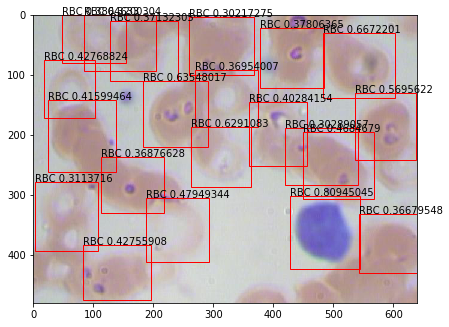

In [17]:
# take random index
idx = rng.choice(range(data.shape[0])) 

# load image
image = plt.imread('../datasets/blood_cell_detection/images/' + data.iloc[idx].filename.split('.')[0] + '.jpg')

# preprocess image for network
image_bgr = read_image_bgr('../datasets/blood_cell_detection/images/' + data.iloc[idx].filename.split('.')[0] + '.jpg')
image_preproccessed = preprocess_image(image)

image_preproccessed, scale = resize_image(image_preproccessed)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image_preproccessed, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# get all indices for score greater than threshold
indices = np.nonzero(scores[0] > 0.3)[0]

# get corresponding bounding box predictions and labels
boxes_to_plot = boxes[0][indices].astype(int)
scores_to_plot = scores[0][indices]
labels_to_plot = labels[0][indices]

# draw emtpy figure
fig = plt.figure()

# define axis
ax = fig.add_axes([0, 0, 1, 1])

# plot image
plt.imshow(image)
    
# for each row
for box, score, label in zip(boxes_to_plot, scores_to_plot, labels_to_plot):
    # get actual coordinates
    xmin = box[0]
    ymin = box[1]
    xmax = box[2]
    ymax = box[3]
    
    # find width and height
    width = xmax - xmin
    height = ymax - ymin
    
    # set different bounding box colors
    if labels_to_names[label] == 'RBC':
        edgecolor = 'r'
    elif labels_to_names[label] == 'WBC':
        edgecolor = 'b'
    elif labels_to_names[label] == 'Platelets':
        edgecolor = 'g'
    
    # create rectangular patch
    rect = patches.Rectangle((xmin, ymin), width, height, edgecolor=edgecolor, facecolor='none')
    
    # add patch
    ax.add_patch(rect)
    
    # annotate the patch
    ax.annotate(xy=(xmin, ymin), s=labels_to_names[label] + " " + str(score))

# show figure
plt.show()